In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
imgPaths = list(paths.list_images('C:\\Users\\sovin\\Desktop\\FACE\\dataset'))
data = []
labels = []

for imagePath in imgPaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\sovin\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

HModel = baseModel.output
HModel = AveragePooling2D(pool_size=(7, 7))(HModel)
HModel = Flatten(name="flatten")(HModel)
HModel = Dense(128, activation="relu")(HModel)
HModel = Dropout(0.5)(HModel)
HModel = Dense(2, activation="softmax")(HModel)


model = Model(inputs=baseModel.input, outputs=HModel)

for layer in baseModel.layers:
	layer.trainable = False

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 138s 1s/step - loss: 0.3937 - accuracy: 0.8243 - val_loss: 0.1020 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 137s 1s/step - loss: 0.1279 - accuracy: 0.9532 - val_loss: 0.0605 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 135s 1s/step - loss: 0.0825 - accuracy: 0.9743 - val_loss: 0.0475 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 137s 1s/step - loss: 0.0603 - accuracy: 0.9789 - val_loss: 0.0407 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 138s 1s/step - loss: 0.0605 - accuracy: 0.9806 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 6/20
95/95 [==============================] - 138s 1s/step - loss: 0.0536 - accuracy: 0.9825 - val_loss: 0.0367 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 136s 1s/step - loss: 0.0437 - accuracy: 0.9868 - val

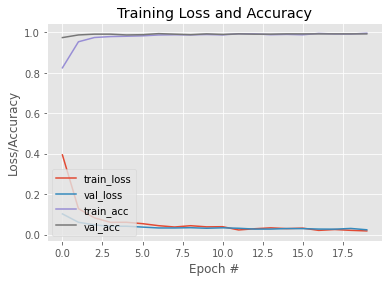

In [9]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [10]:
#To save the trained model
model.save('mask_detection.h5')